# Analyze MLD depth of time series data
(from BCO CTDdat file)

This .ncdf file is a collection of monthly CTD runs at CARIACO Ocean Time Series Station.

In [1]:
require(dplyr, warn.conflicts = FALSE)
#require(cowplot, warn.conflicts = FALSE)
require(oce, warn.conflicts = FALSE)

Loading required package: dplyr
Loading required package: cowplot
Loading required package: ggplot2


In [2]:
# read CTDdat file
ctd <- read.csv("DATA_processed/CTDdat_processed.csv")

# read Date column as POSIXct
ctd$Date <- as.Date(ctd$Date, format="%Y-%m-%d")

In [3]:
names(ctd)

[1] "X"          "CruiseID"   "Date"       "month"      "days"      
 [6] "press"      "depth"      "lat"        "lon"        "sigma_t"   
[11] "sigma_0"    "potemp"     "sal"        "temp"       "beam_att"  
[16] "beam_cp"    "fluor_chla"

In [81]:
head(ctd[ctd$Date=="1997-03-13",])

,X,CruiseID,Date,month,days,press,depth,lat,lon,sigma_t,sigma_0,potemp,sal,temp,beam_att,beam_cp,fluor_chla
16950,16950,93HG_017,1997-03-13,3,71,1.014,1,10.5,-64.67,25.431,25.431,22.409,36.747,22.409,0.905,NA,NA
16951,16951,93HG_017,1997-03-13,3,71,2.048,2,10.5,-64.67,25.430,25.430,22.417,36.748,22.417,0.895,NA,1.687
16952,16952,93HG_017,1997-03-13,3,71,3.056,3,10.5,-64.67,25.428,25.428,22.424,36.749,22.424,0.891,NA,1.746
16953,16953,93HG_017,1997-03-13,3,71,4.047,4,10.5,-64.67,25.457,25.457,22.338,36.754,22.339,0.895,NA,1.951
16954,16954,93HG_017,1997-03-13,3,71,4.952,5,10.5,-64.67,25.518,25.518,22.138,36.760,22.139,0.888,NA,NA
16955,16955,93HG_017,1997-03-13,3,71,6.086,6,10.5,-64.67,25.658,25.658,21.647,36.762,21.649,0.898,NA,NA


## calculate MLD depth, defined as a change in sigma t of 0.125

In [4]:
mld_depth <- ctd %>%
  group_by(CruiseID) %>% # this groups it by the run number 
  filter(press > 8) %>% # only take values below 8 meters depth to minimze influence of surface anomalies
  mutate(belowmld = sigma_t >= sigma_t[10]+0.125 | sigma_t <= sigma_t[1]-0.125) %>% # create new column that gives "True" for values below MLD
  filter(belowmld == T) %>% # only take "True" values 
  slice(1) %>% # takes the first occurrence
  ungroup() #removes grouping

# 1. interpolate potential temperature to 1 meter grid

In [ ]:
zz <- seq(0, 200, 1)

In [69]:
ctd_int <- ctd %>%
    group_by(Date) %>%
    do(data.frame(potemp_int = with(.,oceApprox(depth, potemp, zz, "rr")), depth = zz)) 

In [70]:
head(ctd_int)

Date,potemp_int,depth
1995-11-08,NA,0
1995-11-08,NA,1
1995-11-08,27.52200,2
1995-11-08,27.50500,3
1995-11-08,27.48800,4
1995-11-08,27.47427,5


# 2. calculate differential of pot temp (y[i]-y[i+1],...)

In [73]:
ctd_diff <- ctd_int %>%
    group_by(Date) %>%
    do(data.frame( potemp_int = .$potemp_int, potemp_diff = c(NA,diff(.$potemp_int)), depth = .$depth))

In [74]:
tail(ctd_diff)

Date,potemp_int,potemp_diff,depth
2013-03-13,18.05782,-0.0104707666,195
2013-03-13,18.04858,-0.0092397925,196
2013-03-13,18.04656,-0.0020130850,197
2013-03-13,18.04478,-0.0017877323,198
2013-03-13,18.04377,-0.0010070493,199
2013-03-13,18.04293,-0.0008430351,200


In [80]:
head(ctd_diff[ctd_diff$Date=="1997-03-13",])

Date,potemp_int,potemp_diff,depth
1997-03-13,NA,NA,0
1997-03-13,22.409,NA,1
1997-03-13,22.417,0.008,2
1997-03-13,22.424,0.007,3
1997-03-13,22.338,-0.086,4
1997-03-13,22.138,-0.200,5


# for each date, find depth at which threshold of 0.2 is crossed --> MLD depth

In [88]:
mld_depth <- ctd_diff %>%
    group_by(Date) %>%
    filter(depth > 6) %>%
    mutate(mld = potemp_diff >= 0.2 | potemp_diff <= -0.2) %>% # create new column that gives "True" for values at MLD
    filter(mld == T) %>% # only take "True" values 
    slice(1) # takes the first occurrence
    


In [89]:
head(mld_depth, n = 15)

Date,potemp_int,potemp_diff,depth,mld
1995-11-08,27.03373,-0.3522653,23,TRUE
1996-05-09,22.70051,-0.3524877,7,TRUE
1996-06-12,23.70900,-0.2470000,21,TRUE
1996-07-10,25.63700,-0.4130000,14,TRUE
1996-08-06,25.27132,-0.4526775,7,TRUE
1996-09-10,28.70300,-0.2270000,9,TRUE
1996-10-09,27.00500,-0.2120000,7,TRUE
1996-11-10,25.03900,-0.2090000,14,TRUE
1996-12-11,25.71800,-0.3140000,27,TRUE
1997-01-07,21.23600,-0.2480000,62,TRUE


# let's try another way... interpolation!

In [48]:
mld_depth <- ctd %>%
  group_by(Date) %>% # this groups it by the run number 
  filter(press > 2) %>% # only take values below 8 meters depth to minimze influence of surface anomalies
  mutate(belowmld = sigma_t >= sigma_t[1]+0.125 | sigma_t <= sigma_t[1]-0.125) %>% # create new column that gives "True" for values below MLD
  filter(belowmld == T) %>% # only take "True" values 
  slice(1) %>% # takes the first occurrence
  ungroup() #removes grouping

## plot MLD depth over time

In [105]:
29	61	35	32	39

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected numeric constant
1: 29      61
            ^


In [34]:
82.798/133.877*100

[1] 61.84632

In [39]:
35.11/133.877*100

[1] 26.22557

In [41]:
44.47/133.877*100

[1] 33.21706

In [42]:
40.7/133.877*100

[1] 30.40104

Warning message:
“Removed 1215 rows containing missing values (geom_point).”Warning message:
“Removed 1211 rows containing missing values (geom_point).”Warning message:
“Removed 1212 rows containing missing values (geom_point).”Warning message:
“Removed 1210 rows containing missing values (geom_point).”Warning message:
“Removed 1213 rows containing missing values (geom_point).”Warning message:
“Removed 1211 rows containing missing values (geom_point).”Warning message:
“Removed 1211 rows containing missing values (geom_point).”Warning message:
“Removed 1211 rows containing missing values (geom_point).”Warning message:
“Removed 1211 rows containing missing values (geom_point).”

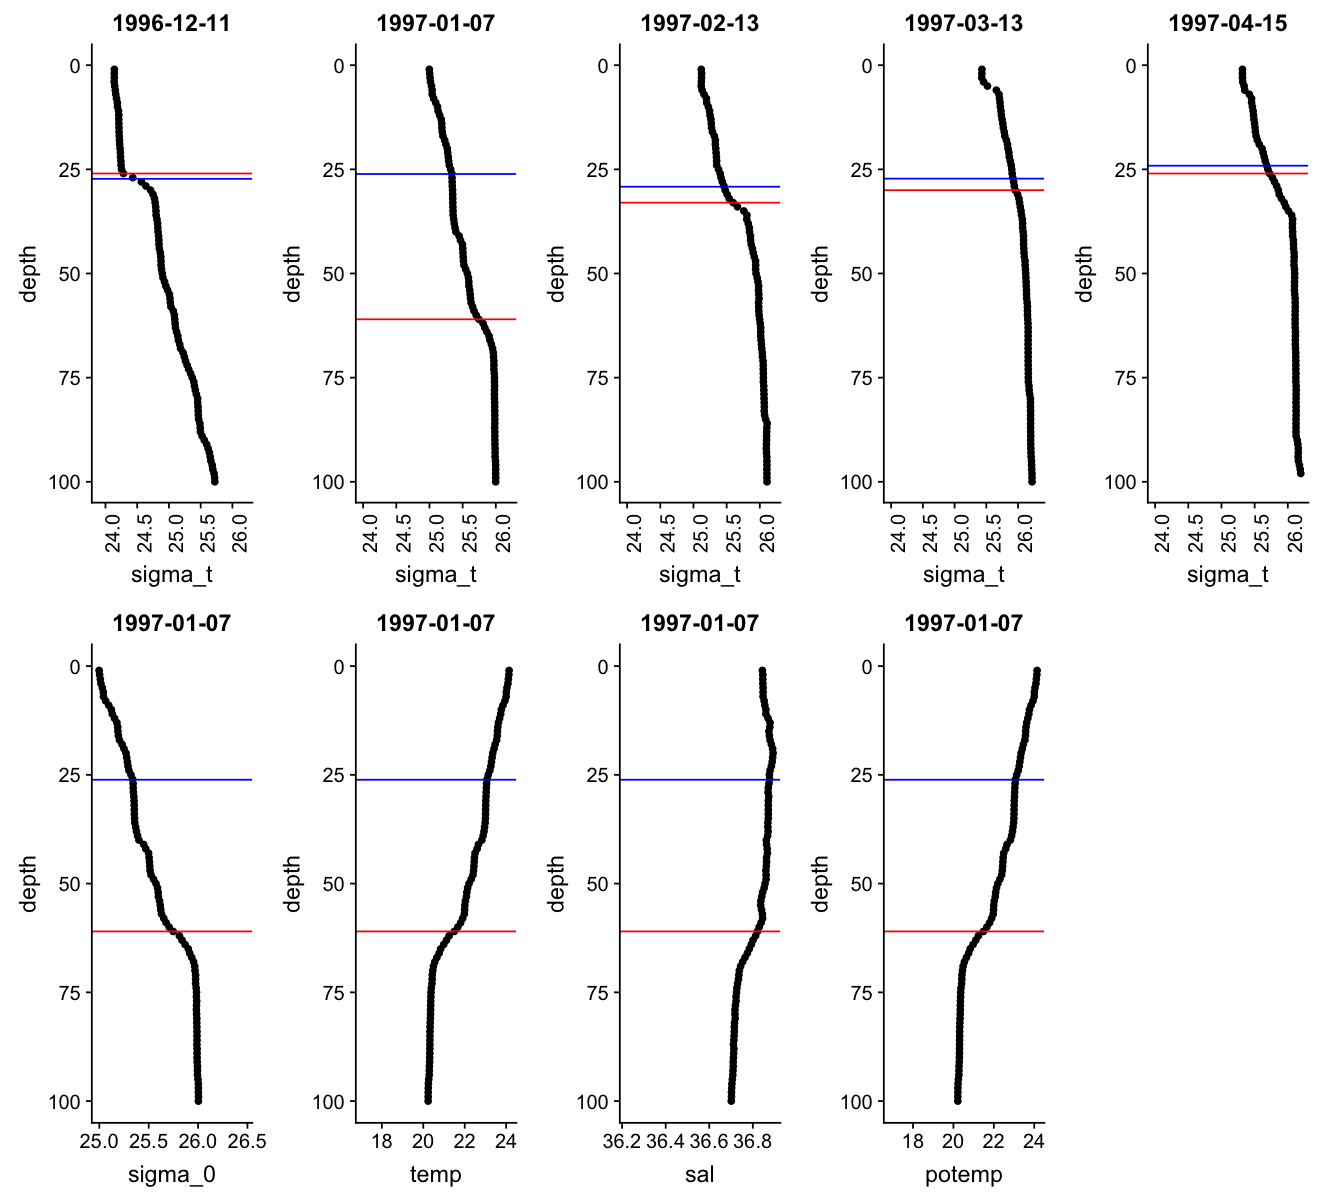

In [81]:
options(repr.plot.width=11, repr.plot.height=10)

dec <- ggplot(ctd[ctd$Date == unique(ctd$Date)[14],])+ geom_point(aes(x=sigma_t, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[14]))+ xlim(23.9,26.2) + geom_hline(yintercept = 26, col = 'red')+
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[14]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

jan <- ggplot(ctd[ctd$Date == unique(ctd$Date)[15],])+ geom_point(aes(x=sigma_t, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[15]))+ xlim(24,26.2) + geom_hline(yintercept = 61, col = 'red')+
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[15]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

feb <- ggplot(ctd[ctd$Date == unique(ctd$Date)[16],])+ geom_point(aes(x=sigma_t, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[16]))+ xlim(24,26.2) + geom_hline(yintercept = 33, col = 'red')+
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[16]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

march <- ggplot(ctd[ctd$Date == unique(ctd$Date)[17],])+ geom_point(aes(x=sigma_t, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[17]))+ xlim(24,26.3) + geom_hline(yintercept = 30, col = 'red')+
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[17]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

apr <- ggplot(ctd[ctd$Date == unique(ctd$Date)[18],])+ geom_point(aes(x=sigma_t, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[18])) + xlim(24,26.2) + geom_hline(yintercept = 26, col = 'red')+
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[18]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 


jan1 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[15],])+ geom_point(aes(x=sigma_0, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[15])) + geom_hline(yintercept = 61, col = 'red')+
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[15]],col='blue')

jan2 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[15],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[15])) + geom_hline(yintercept = 61, col = 'red')+
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[15]],col='blue')

jan3 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[15],])+ geom_point(aes(x=sal, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[15])) + geom_hline(yintercept = 61, col = 'red')+
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[15]],col='blue')

jan4 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[15],])+ geom_point(aes(x=potemp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[15])) + geom_hline(yintercept = 61, col = 'red')+
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[15]],col='blue')


plot_grid(dec,jan,feb,march,apr,jan1,jan2,jan3,jan4, nrow=2)

In [83]:
ggsave('PLOTS/MLD_wtf.png', width=11, height= 10)

Warning message:
“Removed 646 rows containing missing values (geom_point).”Warning message:
“Removed 1255 rows containing missing values (geom_point).”Warning message:
“Removed 1217 rows containing missing values (geom_point).”Warning message:
“Removed 1223 rows containing missing values (geom_point).”Warning message:
“Removed 1215 rows containing missing values (geom_point).”Warning message:
“Removed 1211 rows containing missing values (geom_point).”Warning message:
“Removed 1212 rows containing missing values (geom_point).”Warning message:
“Removed 1210 rows containing missing values (geom_point).”Warning message:
“Removed 1211 rows containing missing values (geom_point).”

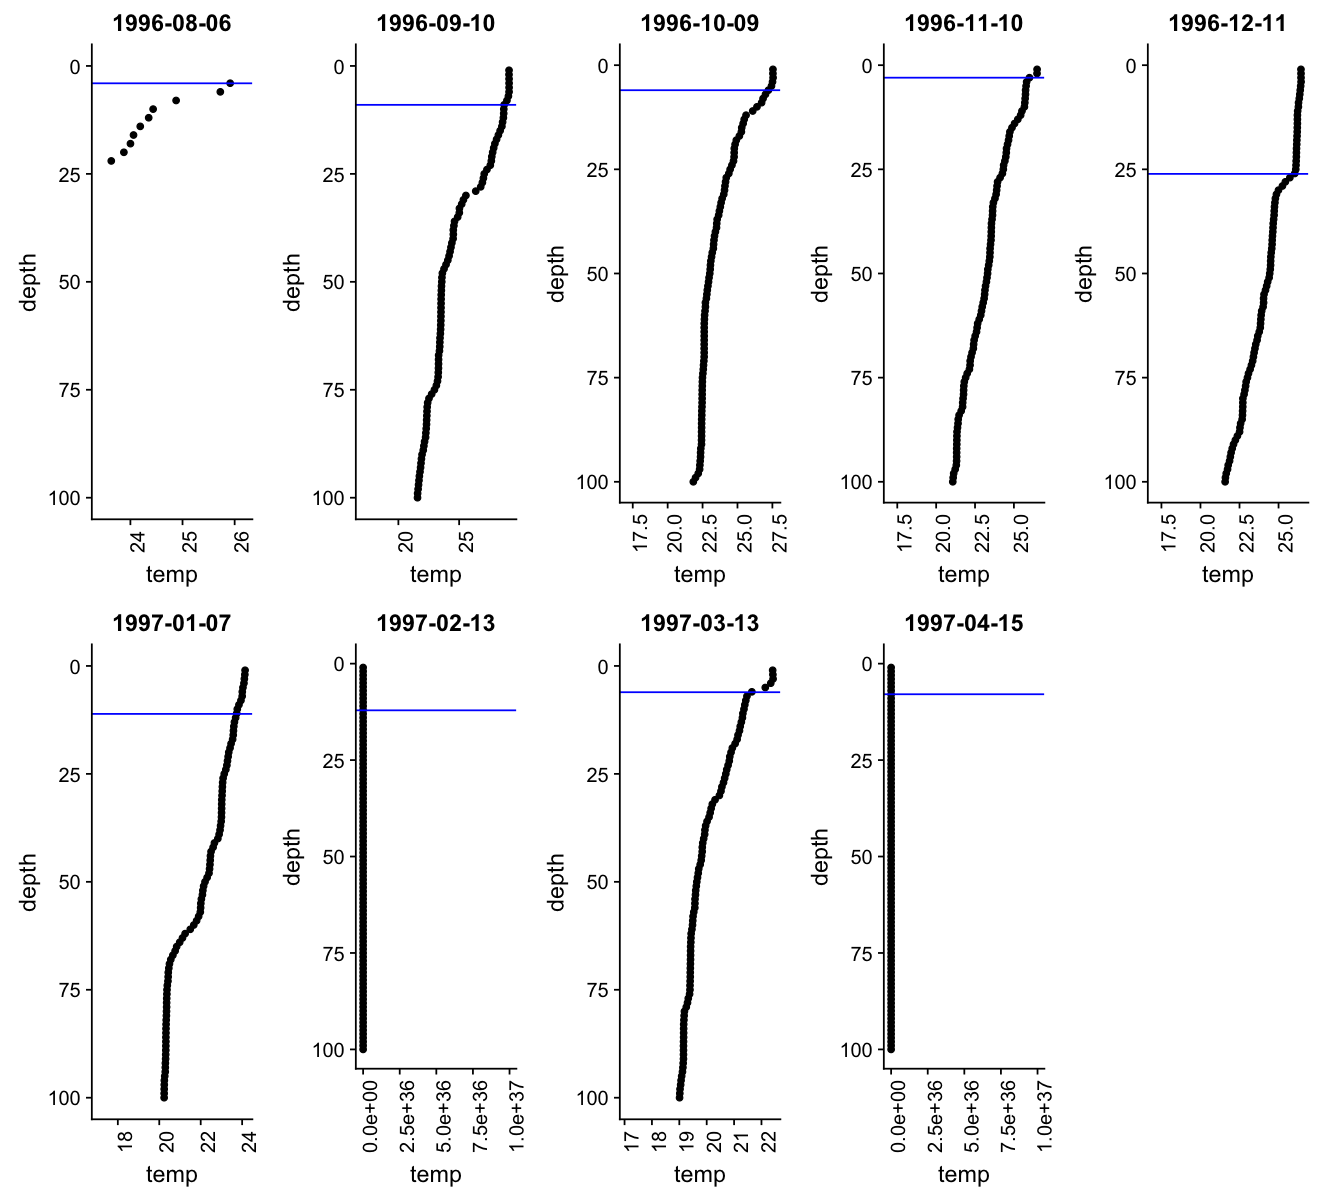

In [52]:
options(repr.plot.width=11, repr.plot.height=10)

i = 10

a1 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[i],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[i]))+ xlim(23.4,26.2) + 
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[i]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

a2 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[i+1],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[i+1]))+ #xlim(24,26.2) + 
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[i+1]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

a3 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[i+2],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[i+2]))+ #xlim(24,26.2) + 
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[i+2]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

a4 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[i+3],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[i+3]))+ #xlim(24,26.3) + 
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[i+3]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

a5 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[i+4],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[i+4])) + #xlim(24,26.2) + 
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[i+4]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

a6 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[i+5],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[i+5])) + #xlim(24,26.2) + 
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[i+5]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

a7 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[i+6],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[i+6])) +# xlim(24,26.2) + 
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[i+6]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

a8 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[i+7],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[i+7])) +# xlim(24,26.2) + 
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[i+7]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 

a9 <- ggplot(ctd[ctd$Date == unique(ctd$Date)[i+8],])+ geom_point(aes(x=temp, y=depth)) + 
scale_y_reverse(limits=c(100,0)) + ggtitle(paste(unique(ctd$Date)[i+8])) +# xlim(24,26.2) + 
geom_hline(yintercept = mld_depth$press[mld_depth$Date == unique(ctd$Date)[i+8]],col='blue')+
theme(axis.text.x = element_text(angle = 90)) 


plot_grid(a1,a2,a3,a4,a5,a6,a7,a8,a9, nrow=2)

In [13]:
ctd[ctd$Date == unique(ctd$Date)[14],]

,X,CruiseID,Date,month,days,press,depth,lat,lon,sigma_t,sigma_0,potemp,sal,temp,beam_att,beam_cp,fluor_chla
13012,13012,93HG_014,1996-12-11,12,345,1.050,1,10.5,-64.67,24.140,24.140,26.435,36.645,26.435,NA,NA,0.212
13013,13013,93HG_014,1996-12-11,12,345,2.002,2,10.5,-64.67,24.139,24.139,26.438,36.645,26.438,0.525,NA,0.203
13014,13014,93HG_014,1996-12-11,12,345,3.061,3,10.5,-64.67,24.139,24.139,26.437,36.645,26.438,0.516,NA,0.203
13015,13015,93HG_014,1996-12-11,12,345,3.954,4,10.5,-64.67,24.137,24.137,26.442,36.645,26.443,0.510,NA,0.202
13016,13016,93HG_014,1996-12-11,12,345,5.090,5,10.5,-64.67,24.146,24.147,26.416,36.646,26.417,0.513,NA,0.195
13017,13017,93HG_014,1996-12-11,12,345,5.921,6,10.5,-64.67,24.155,24.155,26.387,36.645,26.388,0.511,NA,0.203
13018,13018,93HG_014,1996-12-11,12,345,7.056,7,10.5,-64.67,24.163,24.164,26.358,36.644,26.360,0.511,NA,0.192
13019,13019,93HG_014,1996-12-11,12,345,8.037,8,10.5,-64.67,24.174,24.174,26.326,36.645,26.328,0.512,NA,0.178
13020,13020,93HG_014,1996-12-11,12,345,9.011,9,10.5,-64.67,24.187,24.188,26.278,36.643,26.280,0.511,NA,0.185
13021,13021,93HG_014,1996-12-11,12,345,10.077,10,10.5,-64.67,24.189,24.190,26.269,36.642,26.271,0.511,NA,0.181


ERROR: Error in read.ctd("CTDdat_processed.csv"): Cannot discover type in line '"","CruiseID","Date","month","days","press","depth","lat","lon","sigma_t","sigma_0","potemp","sal","temp","beam_att","beam_cp","fluor_chla"'



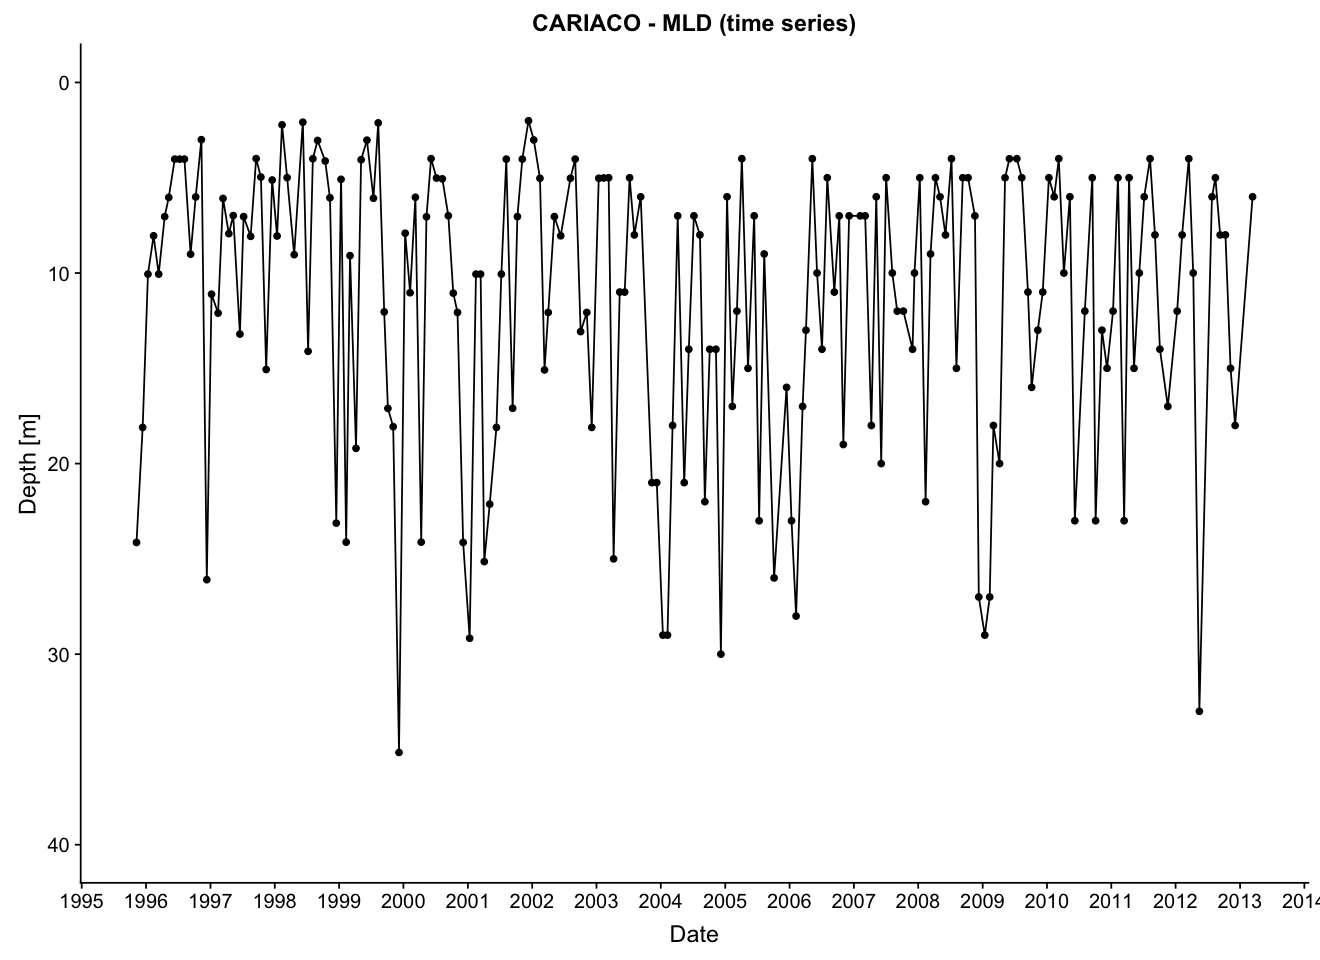

In [49]:
options(repr.plot.width=11, repr.plot.height=8)

ggplot(mld_depth,aes(x=Date,y=press))+
  geom_point()+ geom_line() + scale_y_reverse(lim=c(40,0)) +
  ylab("Depth [m]")+ xlab("Date")+ggtitle("CARIACO - MLD (time series)")+
    scale_x_date(date_breaks = "years", date_labels='%Y')#,limits= c(as.Date("1995/9/1"), as.Date("2001/1/1")))

ggplot(mld_depth,aes(x=days%%365,y=press))+
  geom_point()+stat_smooth(se=F)+ scale_y_reverse(lim=c(70,0)) +
  ylab("Depth [m]")+ xlab("Day of the year")+ggtitle("CARIACO - MLD (yearly)")

## save calculated MLD depth to csv file

In [30]:
# Write CSV
write.csv(mld_depth, file = "DATA_processed/MLD_depth_calculated.csv")